<a href="https://colab.research.google.com/github/piotrwrzodak/UAM-DEEP-LEARNING/blob/master/1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Apr 26 13:54:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%pip install torch_summary
from torchsummary import summary

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
x = [[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9]]
y = [[2],[6],[12],[20],[30],[42],[56],[72]]

tensor(1857.8184, device='cuda:0', grad_fn=<MseLossBackward0>)


Text(0, 0.5, 'loss value')

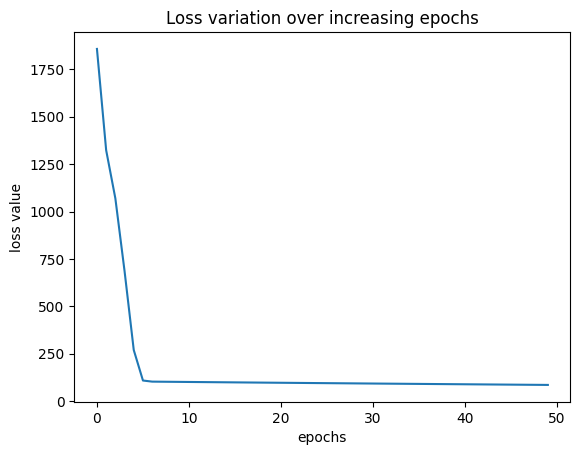

In [5]:
X = torch.tensor(x).float()
Y = torch.tensor(y).float()

X = X.to(device)
Y = Y.to(device)

class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_to_hidden_layer = nn.Linear(2,8)
        self.hidden_layer_activation = nn.ReLU()
        self.hidden_to_output_layer = nn.Linear(8,1)
    def forward(self, x):
        x = self.input_to_hidden_layer(x)
        x = self.hidden_layer_activation(x)
        x = self.hidden_to_output_layer(x)
        return x

mynet = MyNeuralNet().to(device)
loss_func = nn.MSELoss()

_Y = mynet(X)
loss_value = loss_func(_Y,Y)
print(loss_value)


opt = SGD(mynet.parameters(), lr = 0.001)

loss_history = []
for _ in range(50):
    opt.zero_grad()
    loss_value = loss_func(mynet(X),Y)
    loss_value.backward()
    opt.step()
    loss_history.append(loss_value.item())


plt.plot(loss_history)
plt.title('Loss variation over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('loss value')

In [6]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x).float().to(device)
        self.y = torch.tensor(y).float().to(device)
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]
    def __len__(self):
        return len(self.x)

ds = MyDataset(x, y)
dl = DataLoader(ds, batch_size=2, shuffle=True)

def create_model(dimension: int):
  model = nn.Sequential(
      nn.Linear(2, dimension),
      nn.ReLU(), # other: ReLU, Sigmoid, Tanh, Softmax
      nn.Linear(dimension, 1)
  ).to(device)
  return model

def train_model(model: nn.Sequential):
  opt = SGD(model.parameters(), lr = 0.001) # stochastic gradient descent
  loss_func = nn.MSELoss() # other: CrossEntropyLoss (for multinomial classification), BCELoss (binary cross-entropy loss for binary classification)
  loss_history = []
  for _ in range(50): # weight update process for a total of 50 epochs
      for ix, iy in dl:
          opt.zero_grad() # flush the previous epoch's gradients
          loss_value = loss_func(model(ix),iy) # compute loss
          loss_value.backward() # perform back-propagation
          opt.step() # update the weights according to the gradients computed
          loss_history.append(loss_value)


model8 = create_model(8)
model16 = create_model(16)
model32 = create_model(32)
model64 = create_model(64)
model128 = create_model(128)

train_model(model8)
train_model(model16)
train_model(model32)
train_model(model64)
train_model(model128)

### Predictions

In [7]:
def predict(model: nn.Sequential, val):
  val = torch.tensor(val).float()
  return model(val.to(device))

val = [[8,9],[2,6],[4,5]]

print(predict(model8, val))
print(predict(model16, val))
print(predict(model32, val))
print(predict(model64, val))
print(predict(model128, val))


tensor([[51.3279],
        [ 8.5620],
        [22.8061]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[41.8617],
        [ 4.2829],
        [17.6279]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[51.0341],
        [ 6.9028],
        [21.5712]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[59.4369],
        [11.6689],
        [26.1612]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[55.3502],
        [ 9.0149],
        [24.0012]], device='cuda:0', grad_fn=<AddmmBackward0>)


### Saving model

In [8]:
def save_model(model, save_path: str):
  torch.save(model.state_dict(), save_path)
  # !du -hsc {save_path} # size of the model on disk

save_path = 'model8.pth'
save_model(model8, save_path)

### Loading model

In [9]:
model = create_model(8)

def load_model(model: nn.Sequential, save_path: str):
  return model.load_state_dict(torch.load(save_path))

load_model(model, save_path)

<All keys matched successfully>